## Corona Virus Ecuador

**Lenin G. Falconi**

**Marzo 20, 2020**

Para los cálculos presentados a continuación se considera como base:

https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

### Navegación por la presentación:
* Para ir hacia adelante: barra espaciadora
* Para retornar: shift + barra espaciadora

### Data
* La data utilizada es la proporcionada por la posta en una gráfica publicada con datos hasta 18 marzo.
* La data la he actualizado con reportes de casos al 22 de marzo.

### Objetivos:
* Aproximar un modelo de regresión logística para el comportamiento de contagio sin control en Ecuador
* Aproximar modelos de otros países. Para interpolar a los datos locales. (Pendiente)
* Corregir los cálculos del primer objetivo considerando el factor movilidad (Pendiente)

### Objetivos:
* Modelar considerando cómo el número de hospitales, número de respiradores, número de población con movilidad restringida? Para un enfoque de aprendizaje supervisado se require de datos para esta etapa. 


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Data
Organizo los datos del gráfico de **La Posta** en un archivo csv

In [2]:
os.listdir()

['rise.css',
 'CoronaVirusEcu.ipynb',
 '.gitignore',
 'environment.yml',
 'coronavirusEcu.csv',
 '.ipynb_checkpoints',
 'README.md',
 'images',
 '.git',
 'environment.nouse',
 'coronavirusEcu_formatted.csv']

In [3]:
df = pd.read_csv('coronavirusEcu.csv')
df


,Date,Number_of_Cases
0,2020-02-28,0
1,2020-02-29,1
2,2020-03-01,6
3,2020-03-02,7
4,2020-03-04,10
5,2020-03-05,13
6,2020-03-06,14
7,2020-03-08,15
8,2020-03-10,17
9,2020-03-12,19


Se obtiene el gráfico original de los datos proveídos

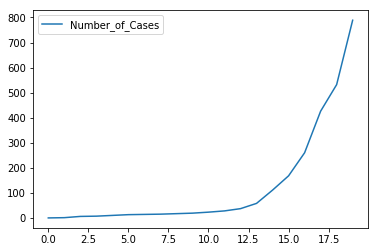

In [4]:
df.plot.line()


En forma similar a la referencia seguida en esta presentación, se convierte las fechas a números considerando al 1 de enero de 2020 como día 1 del año. Esto se podría replantear considerando más bien al inicio de la infección como el día 1. Posiblemente, por facilidad el autor original ha considerado usar este presupuesto para calcular el día de climax de infección.

In [5]:
FMT = '%Y-%m-%d'
date = df['Date']
df['Date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )
df

,Date,Number_of_Cases
0,58,0
1,59,1
2,60,6
3,61,7
4,63,10
5,64,13
6,65,14
7,67,15
8,69,17
9,71,19


Esta nueva tabla de valores se guarda en un nuevo csv para facilidad de uso y verificar los cálculos en otras herramientas como *Matlab*

In [6]:
df.to_csv('coronavirusEcu_formatted.csv')

Extracción de los datos en variables $x$ y  $y$, para modelar una ecuación paramétrica del tipo $y=f(x)$

In [7]:
y = np.array(df['Number_of_Cases'].values.tolist())
y

array([  0,   1,   6,   7,  10,  13,  14,  15,  17,  19,  23,  28,  37,
        58, 111, 168, 260, 426, 532, 789])

In [8]:
# x = np.array(df.index.tolist())
# x = df.index.tolist()
x = np.array(df['Date'])
x

array([58, 59, 60, 61, 63, 64, 65, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81])

Se define el modelo logístico de acuerdo a la ecuación presentada en la publicación original. No obstante, ésta puede ser reformulada y debería considerar factores atenuantes. La ecuación es:

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

$y = c(1+e^{-\frac{x-b}{a}})^{-1}$

Donde:
* $y$: número de contagiados o casos totales
* $x$: día del año para el que se tiene un valor determinado de contagiados
* $a$: velocidad de infección.
* $b$: día en el que ocurre el máximo de infecciones
* $c$: total de infectados en la población.

In [9]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

Ajuste de curva considerando valores iniciales indicados.

In [10]:
popt, pcov = curve_fit(logistic_model,x,y, p0=[10, 80, 2e4],  method='lm', maxfev=4000)
popt

array([2.14293019e+00, 8.22962536e+01, 2.21006410e+03])

In [11]:
(a_, b_, c_) = popt

Matriz Covariante

In [12]:
np.diag(pcov)

array([2.90218624e-02, 1.19017385e+00, 4.64361266e+05])

Error standard para cada parámetro:

In [13]:
np.sqrt(np.diag(pcov))

array([1.70358042e-01, 1.09095089e+00, 6.81440582e+02])

Con los datos adicionales a los dias 22 de marzo, el error del parámetro $c$ se reduce. Esto podría confirmar la necesidad de interpolar artificialmente los datos

In [14]:
errors_values = np.sqrt(np.diag(pcov))
errors_variables = ["a_err", "b_err", "c_err"]
errors_dict = dict(zip(errors_variables, errors_values))
errors_dict

{'a_err': 0.17035804182900488,
 'b_err': 1.0909508939735966,
 'c_err': 681.4405815892403}

Para los mismos datos se hace una predicción según el ajuste de curva, obteniendo los siguientes valores. Note que no se han redondeado los números a valores enteros.

In [15]:
y_pred = logistic_model(x, *popt)
y_pred

array([2.63285775e-02, 4.19844210e-02, 6.69494652e-02, 1.06758666e-01,
       2.71455392e-01, 4.32843204e-01, 6.90150611e-01, 1.75413244e+00,
       4.45511143e+00, 1.12937358e+01, 1.79549325e+01, 2.84940777e+01,
       4.50922139e+01, 7.10440961e+01, 1.11165118e+02, 1.72120649e+02,
       2.62322763e+02, 3.90733147e+02, 5.63806607e+02, 7.80647610e+02])

En azul se tiene los datos originales y en la curva naranja la curva ajustada

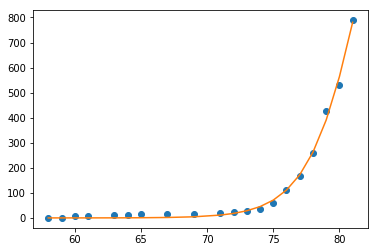

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')

In [17]:
results = {'infection_speed':a_, 'final_day': b_, 'total_infected':c_}

Número total de personas infectadas (en miles):

In [18]:
results['total_infected']/1e3

2.210064100430421

In [19]:
results['total_infected']-errors_dict['c_err']

1528.6235188411804

El pico de infección se obtiene para el día:

In [20]:
sol = int(fsolve(lambda x : logistic_model(x,*popt) - int(c_),b_))
sol

104

La fecha esperada para el pico de infección es:

In [21]:
specific_date = datetime(2020, 1, 1)
new_date = specific_date + timedelta(sol)
print('año:{} mes:{} día: {}'.format(new_date.year, new_date.month, new_date.day))

año:2020 mes:4 día: 14


Cuántos casos se espera para hoy?

In [22]:
dt = datetime.today()
target_date = datetime(dt.year, dt.month, dt.day)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('fecha objetivo {} corresponde al día {} con respecto al 01/01/20'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicción del número de infecciones: {}'.format(y_day))

fecha objetivo 2020-03-25 00:00:00 corresponde al día 84 con respecto al 01/01/20
Predicción del número de infecciones: 1522.5476466591117


Para la fecha de máxima infecciones, cuántas infecciones?

In [23]:
target_date = datetime(2020, 5, 31)
initial_date = datetime(2020, 1, 1)
x_day = (target_date-initial_date).days
print('target date {} corresponds to day # {}'.format(target_date, x_day))
y_day = logistic_model(x_day, *popt)
print('Predicted number of infections: {}'.format(y_day))

target date 2020-05-31 00:00:00 corresponds to day # 151
Predicted number of infections: 2210.0641004303943


In [24]:
y_day+errors_dict['c_err']

2891.504682019635

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

In [25]:
import matplotlib.dates as mdates
formatter = mdates.DateFormatter('%b %d')
target_date = datetime(2020, 4, 13)
initial_date = datetime(2020, 1, 1)
x_end = (target_date-initial_date).days
x_pronos = np.arange(start=x[0], stop=x_end, step=1)
y_pronos = logistic_model(x_pronos, *popt)/1e3

## Gráfica de proyecciones al 13 de Abril
Considerando los datos proporcionados hasta el 18 de marzo, se presenta una proyección gráfica hasta el 13 de abril. 

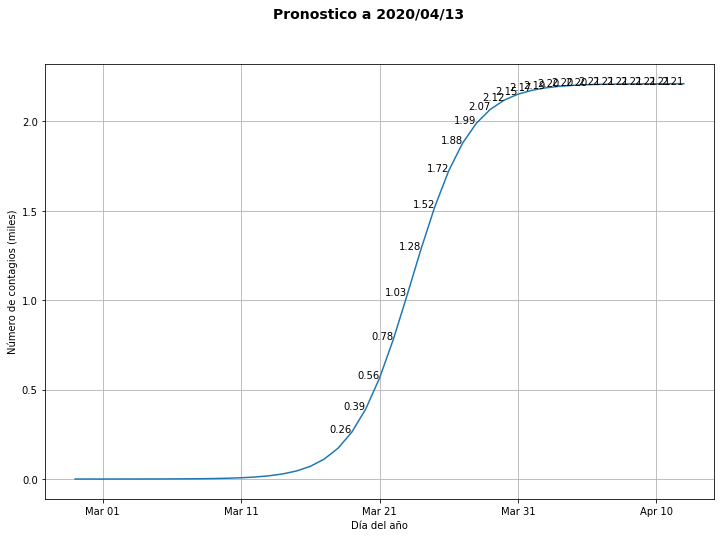

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
fig.suptitle('Pronostico a 2020/04/13', fontsize=14, fontweight='bold')
ax.plot(x_pronos, y_pronos, '-')
for xi,yi in zip(x_pronos,y_pronos):
    if yi>0.2:
        ax.text(xi-0.8, yi, "%.2f" %yi, ha='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Día del año')
ax.set_ylabel('Número de contagios (miles)')
ax.grid(True)
fig.savefig('images/proyectionApril13.png')

<center>
<img src="images/proyectionApril13.png"/>
</center>

Por revisar:
* Usar red neuronal para mapear los datos. Generando un overfitting para generar un incremento artificial de datos, teniendo predicciones para intervalos intermedios de tiempo. Con esta data aumentada, realizar nuevamente el ajuste del modelo, ya que la interpretación de los parámetros de la ecuación permite interpretar información últil.

* Entrenar una red considerando datos más abundantes de otro país. No obstante esto genera el problema de que las condiciones de cada país son diferentes y por tanto la respuesta de cada país es diferente. Por tanto, se pensaría en un modelo global que sea la suma de todos. Luego se podría tratar de especializar las últimas capas del modelo en función de la data particular del país al estilo *transfer learning*.

## Conclusiones
* Quédate en la casa. Al momento los datos indicarían que estamos subiendo por la curva de infección en el primer estadio. 
* Es necesario relantizar dicha pendiente para no colapsar los sistemas médicos.
* Es necesario que las autoridades y otros sectores involucrados traten de proveerse de insumos médicos adicionales. A más de las máscaras, debería observarse la necesidad de respiradores artificiales.

## Conclusiones

* Inicialmente, esto es con datos sólo hasta el 18 de marzo se estimaba, considerando una población total en el Ecuador de 17 millones (https://countrymeters.info/es/Ecuador), que 15 millones terminarían contagiados; en la situación sin restricción de movilidad, implica un contagio del **89%**, estimando alcanzar el pico en 93 días más.
* Con los datos actualizados a 22 de marzo se espera menos contagios y alcanzar el límite de contagios al 14 de Abril de 2020; es decir en 46 días más.
* Los cálculos aquí presentados son referenciales en función de la información disponible y de los modelos presentados. Dado que los factores de restricción de movilidad ya están en ejecución se esperaría que el número de infectados sea menor. Esta es una aproximación simplista del escenario. 




In [27]:
population = 17368483
z = results['total_infected']+errors_dict['c_err']
rate = z/population*100.0
print(rate)
days_remaining = sol-df['Date'].iloc[0]
print(days_remaining)

0.016647997882254087
46


### Artificial Neural Network

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [29]:
def baseline_model():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(1e-4), metrics=['mae', 'mse'])
    return model

model = baseline_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)  

In [30]:
x_stats = df["Date"].describe()
x_stats

count    20.000000
mean     70.100000
std       7.510694
min      58.000000
25%      63.750000
50%      71.500000
75%      76.250000
max      81.000000
Name: Date, dtype: float64

In [31]:
y_stats = df["Number_of_Cases"].describe()
y_stats

count     20.000000
mean     126.700000
std      215.404173
min        0.000000
25%       12.250000
50%       21.000000
75%      125.250000
max      789.000000
Name: Number_of_Cases, dtype: float64

In [32]:
x_norm = (np.array(x)-x_stats['mean'])/x_stats['std']
x_norm

array([-1.61103618, -1.4778927 , -1.34474921, -1.21160572, -0.94531875,
       -0.81217527, -0.67903178, -0.41274481, -0.14645783,  0.11982914,
        0.25297262,  0.38611611,  0.5192596 ,  0.65240308,  0.78554657,
        0.91869005,  1.05183354,  1.18497703,  1.31812051,  1.451264  ])

In [33]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
y_ = np.array(y)
results = cross_val_score(estimator, x_norm, y_, cv=kfold)
print("baseline: {} mse {}".format(results.mean(), results.std()))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
18/18 [==============================] - 0s 17ms/step - loss: 66769.3633 - mean_absolute_error: 140.6392 - mean_squared_error: 66769.3633
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 66692.4032 - mean_absolute_error: 140.4324 - mean_squared_error: 66692.4032
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 66589.2056 - mean_absolute_error: 140.2333 - mean_squared_error: 66589.2056
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 66498.4464 - mean_absolute_error: 139.9158 - mean_squared_error: 66498.4464
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 66329.3188 - mean_absolute_error: 139.5328 - mean_squared_error: 66329.3188
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 66157.3920 - mean_absolute_error: 139.0842 - mean_squared_error: 66157.3920
Epoch 7/100
18/18 [==============================] - 0s 2

In [34]:
y_reg = model.predict(x_norm.reshape(-1,1))
y_reg

array([[-0.03660078],
       [-0.03357593],
       [-0.03055108],
       [-0.02752621],
       [-0.0214765 ],
       [-0.01845164],
       [-0.01542678],
       [-0.00937706],
       [-0.00332735],
       [-0.00311558],
       [-0.00657733],
       [-0.01003908],
       [-0.01350084],
       [-0.01696258],
       [-0.02042435],
       [-0.02388608],
       [-0.02734784],
       [-0.0308096 ],
       [-0.03427135],
       [-0.0377331 ]], dtype=float32)

In [35]:
# from sklearn.model_selection import train_test_split
# x_ = np.array(x)
# y_ = np.array(y)
# x_train, x_test, y_train, y_test = train_test_split(x_,y_, test_size=0.2, random_state=42, shuffle=True)
# print('Numero de casos de entrenamiento: {}'.format(len(x_train)))
# print('Numero de casos de testeo: {}'.format(len(x_test)))
# print("x: {}".format(x_))
# print("y: {}".format(y_))
# print("x_train: {}".format(x_train))
# print("y_train: {}".format(y_train))
# print("x_test: {}".format(x_test))
# print("y_test: {}".format(y_test))
      

In [36]:
history = model.fit(x_norm, y, verbose=1, epochs=1500)

Epoch 1/1500
20/20 [==============================] - 1s 31ms/step - loss: 60139.5625 - mean_absolute_error: 126.7201 - mean_squared_error: 60139.5625
Epoch 2/1500
20/20 [==============================] - 0s 509us/step - loss: 60121.3242 - mean_absolute_error: 126.6662 - mean_squared_error: 60121.3242
Epoch 3/1500
20/20 [==============================] - 0s 527us/step - loss: 60108.5820 - mean_absolute_error: 126.6333 - mean_squared_error: 60108.5820
Epoch 4/1500
20/20 [==============================] - 0s 507us/step - loss: 60095.3750 - mean_absolute_error: 126.5985 - mean_squared_error: 60095.3750
Epoch 5/1500
20/20 [==============================] - 0s 593us/step - loss: 60078.9492 - mean_absolute_error: 126.5631 - mean_squared_error: 60078.9492
Epoch 6/1500
20/20 [==============================] - 0s 570us/step - loss: 60058.7188 - mean_absolute_error: 126.5125 - mean_squared_error: 60058.7188
Epoch 7/1500
20/20 [==============================] - 0s 589us/step - loss: 60040.4688 - 

In [37]:
model.evaluate(x=x_norm, y=y_, verbose=1)

20/20 [==============================] - 0s 16ms/step


[246.65103149414062, 8.216352462768555, 246.65103149414062]

In [38]:
# model.evaluate(x=x_test, y=y_test, verbose=1)

In [39]:
y_pred_cnn = model.predict(x=x_norm)
y_pred_cnn

array([[-5.0463307e-01],
       [ 6.0643762e-01],
       [ 3.7174027e+00],
       [ 6.0542636e+00],
       [ 9.8120604e+00],
       [ 1.1862451e+01],
       [ 1.3165179e+01],
       [ 1.4704057e+01],
       [ 1.6469408e+01],
       [ 1.8797804e+01],
       [ 2.2679888e+01],
       [ 2.7422138e+01],
       [ 3.5889812e+01],
       [ 5.3572590e+01],
       [ 9.9238441e+01],
       [ 1.5441202e+02],
       [ 2.4553073e+02],
       [ 3.8802396e+02],
       [ 5.5656366e+02],
       [ 7.4078259e+02]], dtype=float32)

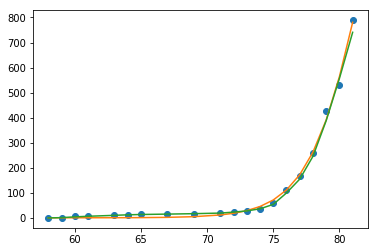

In [40]:
plt.plot(x,y,'o')
plt.plot(x, y_pred)
# plt.plot(x, y_reg)
plt.plot(x, y_pred_cnn)

In [41]:
from sklearn.neural_network import MLPRegressor
x_reg = x_norm.reshape(-1,1)
mlp = MLPRegressor(hidden_layer_sizes=(10,20,10), 
                   tol=1e-4, 
                   max_iter=10000,
                   solver='adam',
                   random_state=0,
                   verbose=1)
mlp.fit(x_reg, y_)

Iteration 1, loss = 30093.18313045
Iteration 2, loss = 30089.75281839
Iteration 3, loss = 30086.30509151
Iteration 4, loss = 30082.84240979
Iteration 5, loss = 30079.34516962
Iteration 6, loss = 30075.81834529
Iteration 7, loss = 30072.26453049
Iteration 8, loss = 30068.64495856
Iteration 9, loss = 30064.99790729
Iteration 10, loss = 30061.29619469
Iteration 11, loss = 30057.52663402
Iteration 12, loss = 30053.70198780
Iteration 13, loss = 30049.74675660
Iteration 14, loss = 30045.71810057
Iteration 15, loss = 30041.51875581
Iteration 16, loss = 30037.13403398
Iteration 17, loss = 30032.54319687
Iteration 18, loss = 30027.90131071
Iteration 19, loss = 30023.20630359
Iteration 20, loss = 30018.46011266
Iteration 21, loss = 30013.66403729
Iteration 22, loss = 30008.81886212
Iteration 23, loss = 30003.90220126
Iteration 24, loss = 29998.91055796
Iteration 25, loss = 29993.86987650
Iteration 26, loss = 29988.78054555
Iteration 27, loss = 29983.64261532
Iteration 28, loss = 29978.45809747
I

/home/leninml/anaconda3/envs/MachineLearning/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [42]:
y_new_pred = mlp.predict(x_reg)
y_new_pred

array([  1.31528064,   2.95572994,   4.59620434,   6.23667873,
         9.51762753,  11.15810192,  12.79857632,  16.07952511,
        18.15026422,  19.821717  ,  22.78301863,  27.59811307,
        36.99760487,  58.01616584, 110.9281904 , 168.07281021,
       259.9892392 , 400.85205499, 582.33659818, 763.82114137])

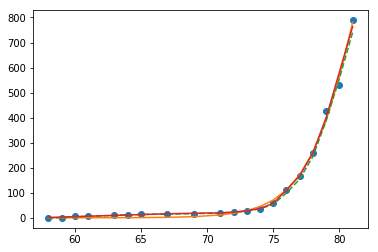

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(x, y, '--k')
ax.plot(x, y, 'o')
ax.plot(x, y_pred, '-')
# ax.plot(x, y_reg, '-')
ax.plot(x, y_pred_cnn, '--')
ax.plot(x, y_new_pred, '-')

In [44]:
x_Day = np.array([100])
x_Day = x_Day.reshape(1,-1)
y_day = mlp.predict(x_Day)
y_day

array([86998.37442515])